In [1]:
"""
Plot Fisher information at different timepoints during training (Figure 9)
"""

import matplotlib.pyplot as plt
import os, sys
import numpy as np
from matplotlib import cm
import matplotlib.lines as mlines
import pandas as pd
import scipy.ndimage
from copy import deepcopy

##%% paths
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code', 'analysis_code'))
import load_activations
import plot_utils
colors_main, colors_sf = plot_utils.get_cmaps_biasCNN()
baseline_inds, card_inds, obl_inds, twent_inds = plot_utils.get_fi_bin_pars()

figfolder = os.path.join(root,'figures','FisherInfoPop')

In [2]:
# Parameters

# loading trained-upright network at several training timepts.
training_strs=['scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos']
ckpt_strs=['50000','100000','200000','400000']
nInits_list = [1,1,1,1]
color_inds=[1,1,1,1]

# define other basic parameters
nImageSets = 4
model='vgg16'
param_str='params1'
param_strs=[]
for ii in range(np.max(nInits_list)):    
  if ii>0:
    param_strs.append(param_str+'_init%d'%ii)
  else:
    param_strs.append(param_str)

dataset_str=['FiltIms14AllSFCos'] # this is just the codename for my main filtered image set
nTrainingSchemes = np.size(training_strs)

 # values of "delta" to use for fisher information
delta_vals = np.arange(1,10,1)
nDeltaVals = np.size(delta_vals)

# this image set doesn't have diff spatial frequency levels (always broadband)
sf_labels=['broadband SF']
nSF=1
sf=0

In [3]:
#%% load the data (Fisher information calculated from each layer)
all_fisher = []
all_recall5 = []

# load activations for each training set of images (training schemes)
for tr in range(nTrainingSchemes):
  training_str = training_strs[tr]
  ckpt_num = ckpt_strs[tr]
  dataset_all = dataset_str[0]
  nInits = nInits_list[tr]
  all_recall5_this_tr = []
  
  # different initializations with same training set
  for ii in range(nInits):
 
    param_str=param_strs[ii]
    
    # load performance of model during its training
    perf_save_path = os.path.join(root,'logs',model,'ImageNet',training_str,param_str)
    fn=os.path.join(perf_save_path,'run-%s.-tag-eval_metrics_eval_recall_5.csv'%param_str)
    vals = pd.read_csv(fn).values    
    all_recall5_this_tr.append(vals)
  
    # different versions of the evaluation image set (samples)
    for kk in range(nImageSets):
           
      dataset = '%s_rand%d'%(dataset_all,kk+1)
       
      if ii==0 and kk==0:
        info = load_activations.get_info(model,dataset)
        layer_labels = info['layer_labels']
        nOri = info['nOri']
        ori_axis = np.arange(0, nOri,1)
        
      # find the exact number of the checkpoint 
      ckpt_dirs = os.listdir(os.path.join(root,'saved_analyses','fisher_info',model,training_str,param_str,dataset))
      ckpt_dirs = [dd for dd in ckpt_dirs if 'eval_at_ckpt-%s'%ckpt_num[0] in dd and '_full' in dd]
      nums=[dir[np.char.find(dir,'-')+1:np.char.find(dir,'_full')] for dir in ckpt_dirs]            
  
      save_path = os.path.join(root,'saved_analyses','fisher_info',model,training_str,param_str,dataset,'eval_at_ckpt-%s_full'%nums[0],'Fisher_info_all_units.npy')
      print('loading from %s\n'%save_path)
      
      # Fisher info array is [nLayer x nSF x nOri x nDeltaValues] in size
      FI = np.load(save_path)
      
      if kk==0 and tr==0 and ii==0:
        nLayers = info['nLayers']         
        nOri = np.shape(FI)[2]      
        # initialize this ND array to store all Fisher info calculated values
        all_fisher = np.zeros([nTrainingSchemes, np.max(nInits_list), nImageSets, nLayers, nSF, nOri, nDeltaVals])
       
      all_fisher[tr,ii,kk,:,sf,:,:] = np.squeeze(FI);
      
  all_recall5.append(all_recall5_this_tr) 

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos_rand1/eval_at_ckpt-50514_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos_rand2/eval_at_ckpt-50514_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos_rand3/eval_at_ckpt-50514_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos_rand4/eval_at_ckpt-50514_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos_rand1/eval_at_ckpt-101125_full/Fisher

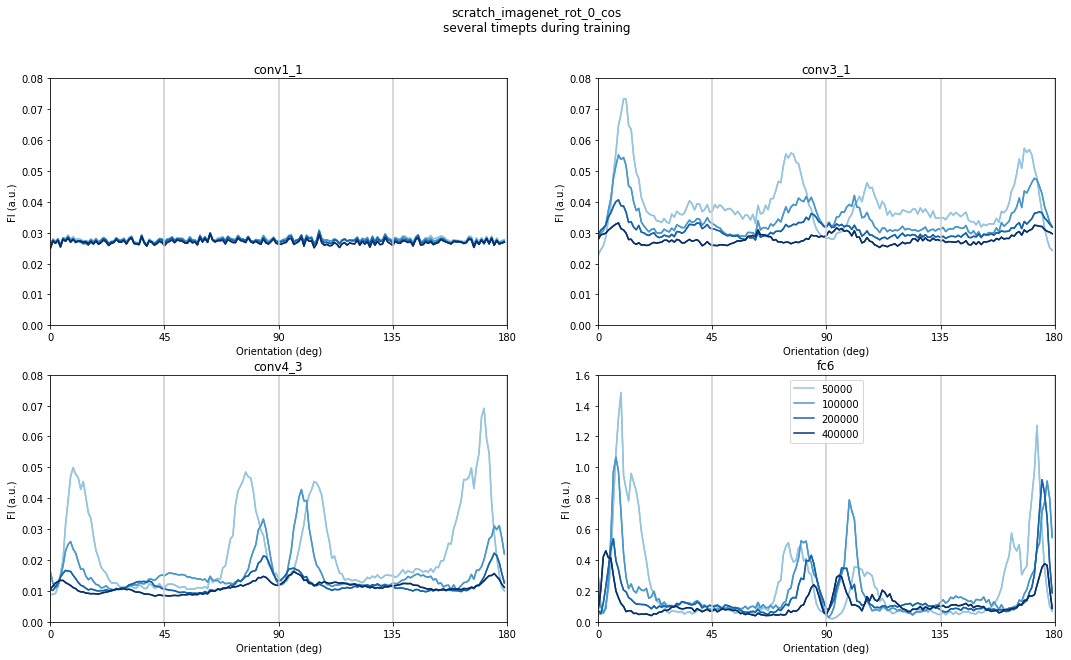

In [4]:
# %%  Plot Fisher information for four example layers, overlay time steps. Save. 

# Figure 9A

layers2plot = np.asarray([0,6,12,18])

tr2plot=[0,1,2,3] 
cols_grad = np.moveaxis(np.expand_dims(cm.Blues(np.linspace(0,1,len(tr2plot)+2)),axis=2),[0,1,2],[0,2,1])
cols_grad = cols_grad[np.arange(2,2+len(tr2plot),1),:,:]

init2plot = [0]

sf=0
dd=3

plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[18,10]

plt.close('all')

fig=plt.figure()
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)

ylims = [[0,0.08],[0,0.08],[0,0.08],[0,1.6]]
# loop over layers, making a subplot for each
for ll in range(np.size(layers2plot)):

  ax=plt.subplot(npx,npy, ll+1)
  allh=[]
  
  for tr in range(len(tr2plot)):
  
    FI_all_init = np.zeros([len(init2plot),nOri])
    
    for ii in init2plot:
      
      fish= all_fisher[tr2plot[tr],ii,:,layers2plot[ll],sf,:,dd] 
      # correct for the different numbers of units in each layer
      nUnits = info['activ_dims'][layers2plot[ll]]**2*info['output_chans'][layers2plot[ll]]  
      fish = fish/nUnits  

      FI_all_init[ii,:] = np.mean(fish,axis=0)

    meanfish = np.mean(FI_all_init,0)    
    errfish = np.std(FI_all_init,0)
   
    if len(init2plot)>1:
      plt.errorbar(ori_axis,meanfish,errfish,ecolor=cols_grad[tr,0,:],color=[0,0,0])
    else:
      plt.plot(ori_axis,meanfish,color=cols_grad[tr,0,:])
    
    myline = mlines.Line2D(ori_axis,meanfish,color=cols_grad[tr,0,:])
    ax.add_line(myline)   
    allh.append(myline)
    
  # finish up this subplot    
  plt.title('%s' % (layer_labels[layers2plot[ll]]))

  plt.xlim([np.min(ori_axis),np.max(ori_axis)])
  plt.ylim(ylims[ll])
 
  if ll==len(layers2plot)-1:
     plt.legend(allh, ckpt_strs)     
  else:
    plt.xticks([])

  plt.xlabel('Orientation (deg)')
  plt.xticks(np.arange(0,181,45))
  plt.ylabel('FI (a.u.)')   
  for xx in np.arange(0,181,45):
      plt.axvline(xx,color=[0.8, 0.8, 0.8])
      
# finish up the entire plot   
plt.suptitle('%s\nseveral timepts during training' % (training_strs[tr]))
figname = os.path.join(figfolder, 'FI_overlay_time_%s.pdf'%training_strs[tr])
plt.savefig(figname, format='pdf',transparent=True)


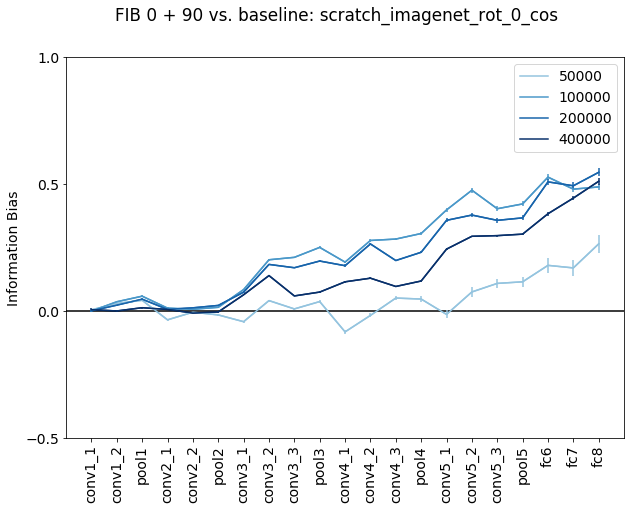

In [5]:
#%% Plot Cardinal Bias - overlaying different timepoints. 

# Figure 9C

# which type of FIB to plot?
pp=0  # set to 0, 1 or 2 to plot [FIB-0, FIB-22, FIB-45]

tr2plot=[0,1,2,3] 
cols_grad = np.moveaxis(np.expand_dims(cm.Blues(np.linspace(0,1,len(tr2plot)+2)),axis=2),[0,1,2],[0,2,1])
cols_grad = cols_grad[np.arange(2,2+len(tr2plot),1),:,:]

ii=0
dd=3
peak_inds=[card_inds, twent_inds,obl_inds]
lstrings=['0 + 90 vs. baseline', '67.5 + 157.5 vs. baseline', '45 + 135 vs. baseline']

plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

allh = []
layers2plot = np.arange(0,nLayers,1)

alpha=0.01;
# for each layer, compare bias for trained models versus random models
pvals_trained_vs_random=np.zeros([1, nLayers])
nTotalComp = np.size(pvals_trained_vs_random)
# matrix to store anisotropy index for each layer    
aniso_vals = np.zeros([len(tr2plot),1,nImageSets,np.size(layers2plot)])

# loop over network layers
for ww1 in range(np.size(layers2plot)):
  # loop over networks with each training set
  for tr in range(len(tr2plot)):
    
    # loop over random image sets
    for kk in range(nImageSets):

      # FI is nOri pts long
      all_fish= np.squeeze(deepcopy(all_fisher[tr2plot[tr],ii,kk,layers2plot[ww1],sf,:,dd]))
      
      # take the bins of interest to get bias
      base_discrim=  all_fish[baseline_inds]
      peak_discrim = all_fish[peak_inds[pp]]
      
      # final value for this FIB: difference divided by sum 
      aniso_vals[tr,ii,kk,ww1] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
  
# put the line for each FIB onto the plot 
# error bars are across 4 image sets
for tr in range(len(tr2plot)):    
  vals = np.squeeze(np.mean(aniso_vals[tr,:,:,:],1))
  errvals = np.squeeze(np.std(aniso_vals[tr,:,:,:],1)) 
  plt.errorbar(np.arange(0,np.size(layers2plot),1),vals,errvals,color=cols_grad[tr,0,:],zorder=21)
  
  myline = mlines.Line2D(np.arange(0,np.size(layers2plot),1),vals,color=cols_grad[tr,0,:])
  ax.add_line(myline)   
  allh.append(myline)
  
# finish up the entire plot
ylims = [-0.5,1]
xlims = [-1, np.size(layers2plot)]
plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
#plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Information Bias')
plt.xticks(np.arange(0,np.size(layers2plot),1),[layer_labels[ii] for ii in layers2plot],rotation=90)

plt.legend(allh, ckpt_strs)
plt.suptitle('FIB %s: %s'%(lstrings[pp], training_strs[tr2plot[tr]]))  
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'Cardbias_overtime_%s.pdf'%lstrings[pp])
plt.savefig(figname, format='pdf',transparent=True)



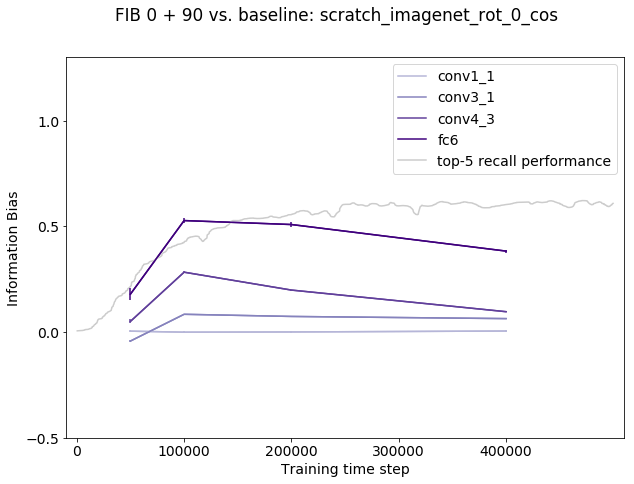

In [6]:
#%% Plot Cardinal FIB, over time, with performance overlaid. 

# Figure 9D

# which type of FIB to plot?
pp=0  # set to 0, 1 or 2 to plot [FIB-0, FIB-22, FIB-45]

layers2plot = np.arange(0,21,6)

#tr2plot=[0,1,2,3] 
cols_layers = np.moveaxis(np.expand_dims(cm.Purples(np.linspace(0,1,len(layers2plot)+2)),axis=2),[0,1,2],[0,2,1])
cols_layers = cols_layers[np.arange(2,2+len(layers2plot),1),:,:]

tax = [int(ck) for ck in ckpt_strs]
ii=0
dd=3
peak_inds=[card_inds, twent_inds,obl_inds]
lstrings=['0 + 90 vs. baseline', '67.5 + 157.5 vs. baseline', '45 + 135 vs. baseline']

plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

allh=[]
#layers2plot = np.arange(0,nLayers,1)

alpha=0.01;
# for each layer, compare bias for trained models versus random models
pvals_trained_vs_random=np.zeros([1, nLayers])
nTotalComp = np.size(pvals_trained_vs_random)
# matrix to store anisotropy index for each layer    
aniso_vals = np.zeros([len(tr2plot),1,nImageSets,np.size(layers2plot)])

# loop over network layers
for ww1 in range(np.size(layers2plot)):
  aniso_vals = np.zeros((len(tr2plot), nImageSets))
  # loop over networks with each training set
  for tr in range(len(tr2plot)):
    
    # loop over random image sets
    for kk in range(nImageSets):

      # FI is nOri pts long
      all_fish= np.squeeze(deepcopy(all_fisher[tr2plot[tr],ii,kk,layers2plot[ww1],sf,:,dd]))
      
      # take the bins of interest to get bias
      base_discrim=  all_fish[baseline_inds]
      peak_discrim = all_fish[peak_inds[pp]]
      
      # final value for this FIB: difference divided by sum 
      aniso_vals[tr,kk] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
  
  # put the line for each layer onto plot
  # error bars across four image sets
  vals = np.squeeze(np.mean(aniso_vals,1))
  errvals = np.squeeze(np.std(aniso_vals,1)) 
  plt.errorbar(tax,vals,errvals,color=cols_layers[ww1,0,:],zorder=21)
#  plt.plot(tax,vals,color=cols_layers[ww1,0,:],zorder=21,marker='o')
  
  myline = mlines.Line2D(tax,vals,color=cols_layers[ww1,0,:])
  ax.add_line(myline)   
  allh.append(myline)
 
# add validation set performance overlaid
smoothing=5
max_ckpt= 500000
x_vals = all_recall5[tr][ii][:,1]
y_vals = all_recall5[tr][ii][:,2]
# smoothing values w gaussian kernel so trend can be better seen
y_vals_smoothed = scipy.ndimage.gaussian_filter1d(y_vals,sigma=smoothing)
inds2plot = np.where(x_vals<max_ckpt)[0]

myline = mlines.Line2D(x_vals[inds2plot],y_vals_smoothed[inds2plot],color=[0.8, 0.8, 0.8])
ax.add_line(myline)   
allh.append(myline)

# finish up the entire plot
ylims = [-0.5,1.3]
xlims = [-1, np.size(layers2plot)]
plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Information Bias')
plt.xlabel('Training time step')
plt.xticks(np.arange(0,500000,100000))
plt.xlim([-10000,max_ckpt+10000])
ll=[layer_labels[ii] for ii in layers2plot]
ll.append('top-5 recall performance')
plt.legend(allh,ll)
plt.suptitle('FIB %s: %s'%(lstrings[pp], training_strs[tr2plot[tr]]))  
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'Bias_overtime_wperf_%s.pdf'%lstrings[pp])
plt.savefig(figname, format='pdf',transparent=True)
